In [2]:
import os
import rpy2.robjects as robjects
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the path to the data folder
data_path = "sessions"

# Function to read an RDS file
def read_rds(file_path):
    readRDS = robjects.r['readRDS']
    return readRDS(file_path)

all_sessions = []
for i in range(1, 19):
    file_name = f'session{i}.rds'
    file_path = os.path.join(data_path, file_name)
    session_data = read_rds(file_path)
    all_sessions.append(session_data)

print(f"Loaded {len(all_sessions)} sessions successfully!")

Loaded 18 sessions successfully!


In [3]:
session1_data = read_rds("sessions/session1.rds")
print(session1_data.names)

[1] "contrast_left"  "contrast_right" "feedback_type"  "mouse_name"    
[5] "brain_area"     "date_exp"       "spks"           "time"          



In [4]:
# Extract spike train matrix for the first trial
trial1_spks = np.array(session1_data.rx2("spks")[0])  # Shape: (n_neurons, n_time_bins)

# Print dimensions (equivalent to `dim()` in R)
print(f"Shape of spike train matrix for Trial 1: {trial1_spks.shape}")  
# Expected output: (734, 40) --> (n_neurons, n_time_bins)

Shape of spike train matrix for Trial 1: (734, 40)


In [5]:
# Extract number of neurons
num_neurons = len(session1_data.rx2("brain_area"))
print(f"Number of neurons in Session 1: {num_neurons}")  
# Expected output: 734

Number of neurons in Session 1: 734


In [6]:
# Extract the spike train of neuron 6 (index 5 in Python, since indexing starts at 0)
neuron_6_spike_train = trial1_spks[5, :]  # 40 time bins
print(f"Spike train of Neuron 6 in Trial 1: {neuron_6_spike_train}")

Spike train of Neuron 6 in Trial 1: [0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [7]:
# Extract the spike count at time bin 3 (index 2 in Python)
neuron_6_bin_3 = trial1_spks[5, 2]
print(f"Neuron 6 spike count at Time Bin 3: {neuron_6_bin_3}")  
# Expected output: 1 if there was a spike, 0 otherwise

Neuron 6 spike count at Time Bin 3: 1.0


In [8]:
# Extract the brain area of neuron 6 (index 5 in Python)
neuron_6_brain_area = session1_data.rx2("brain_area")[5]
print(f"Neuron 6 belongs to brain area: {neuron_6_brain_area}")  
# Expected output: "ACA"

Neuron 6 belongs to brain area: ACA


In [9]:
def get_trial_data(session, trial_id):
    """
    Summarizes neural activity for a given trial:
      - Total spike counts per brain area
      - Number of neurons per brain area
      - Average spike rate per neuron in each brain area
      - Trial metadata (contrast_left, contrast_right, feedback_type)
    """
    spikes = np.array(session.rx2("spks")[trial_id])  # Shape: (n_neurons, n_time_bins)
    neuron_spike = np.sum(spikes, axis=1)  # Sum of spikes over 40 time bins
    brain_area = np.array(session.rx2("brain_area"))  # Brain area for each neuron
    
    df = pd.DataFrame({
        "neuron_spike": neuron_spike,
        "brain_area": brain_area
    })
    
    # Group by brain area and compute summary statistics
    trial_df = (df.groupby("brain_area")
                .agg(region_sum_spike=("neuron_spike", "sum"),
                     region_count=("neuron_spike", "count"),
                     region_mean_spike=("neuron_spike", "mean"))
                .reset_index())

    # Add trial metadata
    trial_df["trial_id"] = trial_id + 1  # 1-based indexing
    trial_df["contrast_left"] = session.rx2("contrast_left")[trial_id]
    trial_df["contrast_right"] = session.rx2("contrast_right")[trial_id]
    trial_df["feedback_type"] = session.rx2("feedback_type")[trial_id]
    
    return trial_df

# Example: Get data for trial 17 in session 1
trial_summary = get_trial_data(session1_data, trial_id=17)
print(trial_summary)

  brain_area  region_sum_spike  region_count  region_mean_spike  trial_id  \
0        ACA             186.0           109           1.706422        18   
1        CA3             154.0            68           2.264706        18   
2         DG             107.0            34           3.147059        18   
3         LS             310.0           139           2.230216        18   
4        MOs             119.0           113           1.053097        18   
5        SUB             199.0            75           2.653333        18   
6       VISp             402.0           178           2.258427        18   
7       root              31.0            18           1.722222        18   

   contrast_left  contrast_right  feedback_type  
0            0.0             0.5            1.0  
1            0.0             0.5            1.0  
2            0.0             0.5            1.0  
3            0.0             0.5            1.0  
4            0.0             0.5            1.0  
5     

In [10]:
def get_trial_bin_average(session):
    """
    Computes the average spike rate per time bin for each trial.
    Each row represents a trial, and each column represents a time bin.
    """
    spks = session.rx2('spks')
    trial_avgs = []
    n_trials = len(spks)
    n_bins = np.array(spks[0]).shape[1]  # Assuming all trials have the same number of bins

    for trial_id in range(n_trials):
        trial_matrix = np.array(spks[trial_id])  # (n_neurons, n_bins)
        bin_avg = np.mean(trial_matrix, axis=0)  # Average across neurons
        trial_avgs.append(bin_avg)

    bin_columns = [f"bin{i+1}" for i in range(n_bins)]
    df = pd.DataFrame(trial_avgs, columns=bin_columns)

    # Add trial metadata
    df["trial_id"] = np.arange(1, n_trials + 1)
    df["contrast_left"] = np.array(session.rx2("contrast_left"))
    df["contrast_right"] = np.array(session.rx2("contrast_right"))
    df["feedback_type"] = np.array(session.rx2("feedback_type"))
    return df

# Example: Get trial bin averages for session 1
trial_bin_avg_df = get_trial_bin_average(session1_data)
print(trial_bin_avg_df.head())

       bin1      bin2      bin3      bin4      bin5      bin6      bin7  \
0  0.049046  0.036785  0.017711  0.014986  0.032698  0.028610  0.031335   
1  0.029973  0.031335  0.034060  0.027248  0.025886  0.031335  0.021798   
2  0.049046  0.050409  0.029973  0.043597  0.024523  0.040872  0.029973   
3  0.055858  0.053134  0.027248  0.061308  0.057221  0.059946  0.044959   
4  0.027248  0.043597  0.031335  0.024523  0.044959  0.038147  0.046322   

       bin8      bin9     bin10  ...     bin35     bin36     bin37     bin38  \
0  0.012262  0.034060  0.019074  ...  0.031335  0.036785  0.050409  0.054496   
1  0.023161  0.023161  0.034060  ...  0.042234  0.053134  0.061308  0.038147   
2  0.038147  0.034060  0.042234  ...  0.029973  0.042234  0.035422  0.027248   
3  0.028610  0.039510  0.035422  ...  0.043597  0.038147  0.027248  0.034060   
4  0.057221  0.047684  0.016349  ...  0.039510  0.047684  0.035422  0.028610   

      bin39     bin40  trial_id  contrast_left  contrast_right  feed

In [11]:
len(session1_data.rx2('spks'))

114

In [12]:
def get_session_summary(all_sessions):
    """
    Computes summary statistics for each session:
    - Number of neurons
    - Number of unique brain areas
    - Average spike rate
    - Success rate
    """
    session_summaries = []

    for session_id, session in enumerate(all_sessions, start=1):
        spks = session.rx2("spks")
        brain_areas = np.array(session.rx2("brain_area"))
        feedback = np.array(session.rx2("feedback_type"))
        n_neurons = len(brain_areas)
        n_brain_areas = len(np.unique(brain_areas))

        # Compute mean session spike rate
        mean_spike_rate = np.mean([np.sum(np.array(trial)) / np.array(trial).size for trial in spks])

        # Compute success rate
        success_rate = np.mean(feedback == 1)

        session_summaries.append({
            "session_id": session_id,
            "n_neurons": n_neurons,
            "n_brain_areas": n_brain_areas,
            "mean_spike_rate": mean_spike_rate,
            "success_rate": success_rate
        })

    return pd.DataFrame(session_summaries)

# Compute session summaries
session_summary_df = get_session_summary(all_sessions)
print(session_summary_df)

    session_id  n_neurons  n_brain_areas  mean_spike_rate  success_rate
0            1        734              8         0.038491      0.605263
1            2       1070              5         0.031641      0.633466
2            3        619             11         0.055848      0.662281
3            4       1769             11         0.021039      0.666667
4            5       1077             10         0.027896      0.661417
5            6       1169              5         0.016580      0.741379
6            7        584              8         0.035384      0.670635
7            8       1157             15         0.041389      0.644000
8            9        788             12         0.039684      0.685484
9           10       1172             13         0.029688      0.619687
10          11        857              6         0.031262      0.795322
11          12        698             12         0.041582      0.738235
12          13        983             15         0.061442      0

/var/folders/6k/4mxbyftd2gvdc46x5202nj5w0000gn/T/ipykernel_2365/563557635.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="session_id", y="n_neurons", data=session_summary_df, palette="coolwarm")


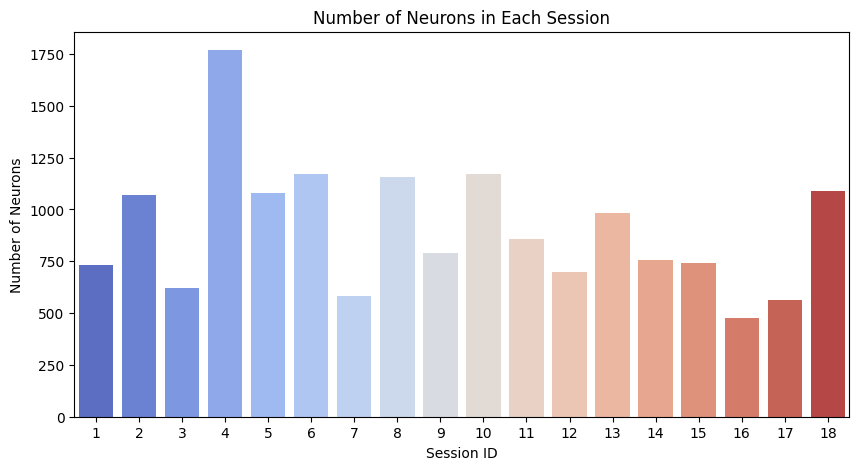

In [13]:
plt.figure(figsize=(10, 5))
sns.barplot(x="session_id", y="n_neurons", data=session_summary_df, palette="coolwarm")
plt.xlabel("Session ID")
plt.ylabel("Number of Neurons")
plt.title("Number of Neurons in Each Session")
plt.show()

/var/folders/6k/4mxbyftd2gvdc46x5202nj5w0000gn/T/ipykernel_2365/2857938582.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="session_id", y="n_brain_areas", data=session_summary_df, palette="viridis")


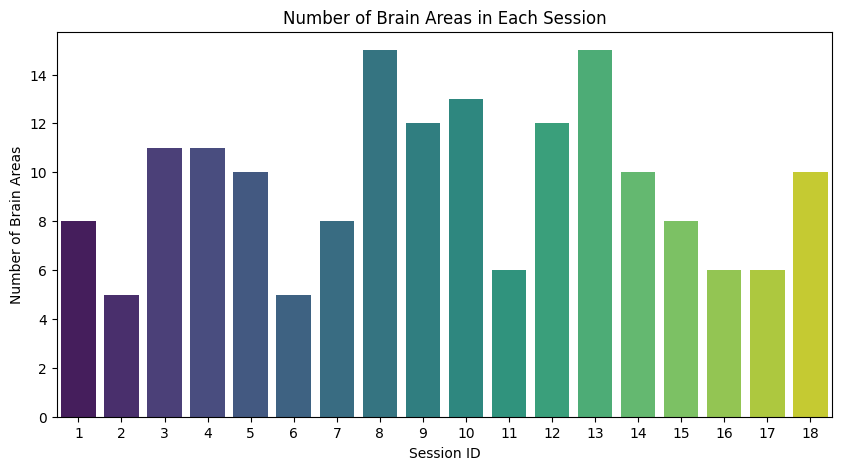

In [14]:
plt.figure(figsize=(10, 5))
sns.barplot(x="session_id", y="n_brain_areas", data=session_summary_df, palette="viridis")
plt.xlabel("Session ID")
plt.ylabel("Number of Brain Areas")
plt.title("Number of Brain Areas in Each Session")
plt.show()

/var/folders/6k/4mxbyftd2gvdc46x5202nj5w0000gn/T/ipykernel_2365/595072985.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="session_id", y="mean_spike_rate", data=session_summary_df, palette="magma")


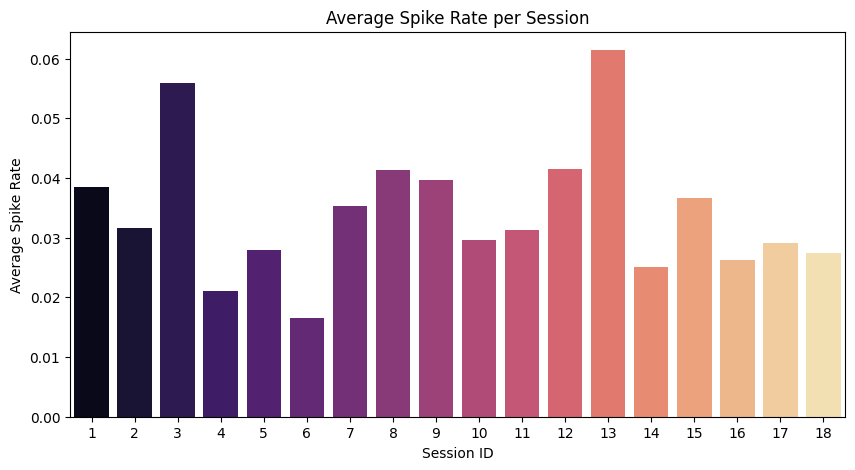

In [15]:
plt.figure(figsize=(10, 5))
sns.barplot(x="session_id", y="mean_spike_rate", data=session_summary_df, palette="magma")
plt.xlabel("Session ID")
plt.ylabel("Average Spike Rate")
plt.title("Average Spike Rate per Session")
plt.show()

/var/folders/6k/4mxbyftd2gvdc46x5202nj5w0000gn/T/ipykernel_2365/3302463456.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="session_id", y="success_rate", data=session_summary_df, palette="Blues")


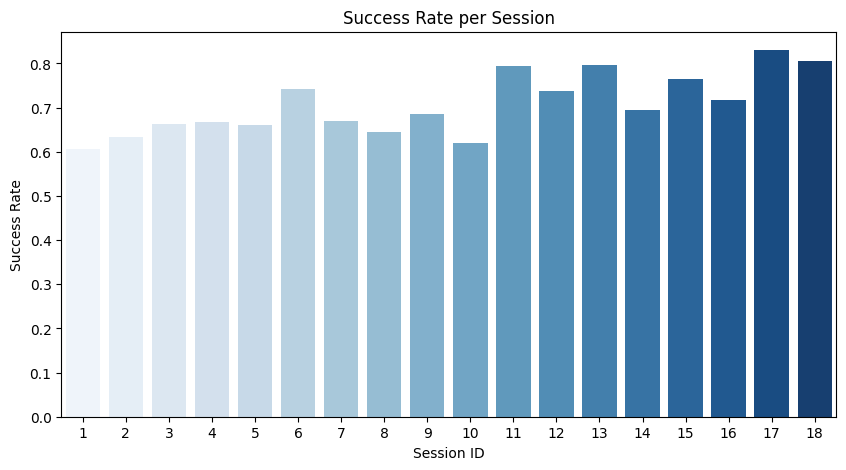

In [16]:
plt.figure(figsize=(10, 5))
sns.barplot(x="session_id", y="success_rate", data=session_summary_df, palette="Blues")
plt.xlabel("Session ID")
plt.ylabel("Success Rate")
plt.title("Success Rate per Session")
plt.show()

In [17]:
def get_contrast_summary(all_sessions):
    """
    Computes contrast differences and success rates for all trials across sessions.
    """
    contrast_data = []

    for session_id, session in enumerate(all_sessions, start=1):
        contrast_left = np.array(session.rx2("contrast_left"))
        contrast_right = np.array(session.rx2("contrast_right"))
        feedback = np.array(session.rx2("feedback_type"))  # 1 for success, -1 for failure

        contrast_diff = np.abs(contrast_left - contrast_right)

        for i in range(len(contrast_diff)):
            contrast_data.append({
                "session_id": session_id,
                "contrast_diff": contrast_diff[i],
                "success": 1 if feedback[i] == 1 else 0  # Convert feedback to binary
            })

    return pd.DataFrame(contrast_data)

# Compute contrast summary
contrast_df = get_contrast_summary(all_sessions)

# Print summary
print(contrast_df.head())

   session_id contrast_diff  success
0           1           0.5        1
1           1           0.0        1
2           1           0.5        0
3           1           0.0        0
4           1           0.0        0


In [18]:
print("Number of NaN values:", contrast_df["contrast_diff"].isna().sum())
print("Total entries:", len(contrast_df))

Number of NaN values: 0
Total entries: 5081


In [19]:
print("Data type:", contrast_df["contrast_diff"].dtype)
# Convert to float if needed
contrast_df["contrast_diff"] = pd.to_numeric(contrast_df["contrast_diff"], errors="coerce")

Data type: object


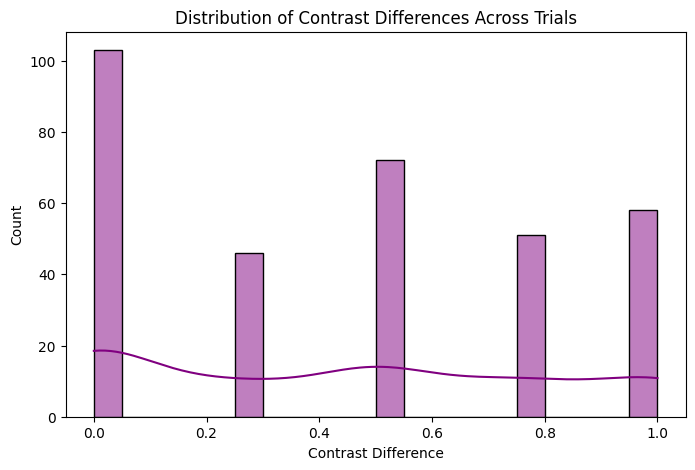

In [20]:
plt.figure(figsize=(8, 5))
sns.histplot(contrast_df["contrast_diff"], bins=20, kde=True, color="purple")
plt.xlabel("Contrast Difference")
plt.ylabel("Count")
plt.title("Distribution of Contrast Differences Across Trials")
plt.show()

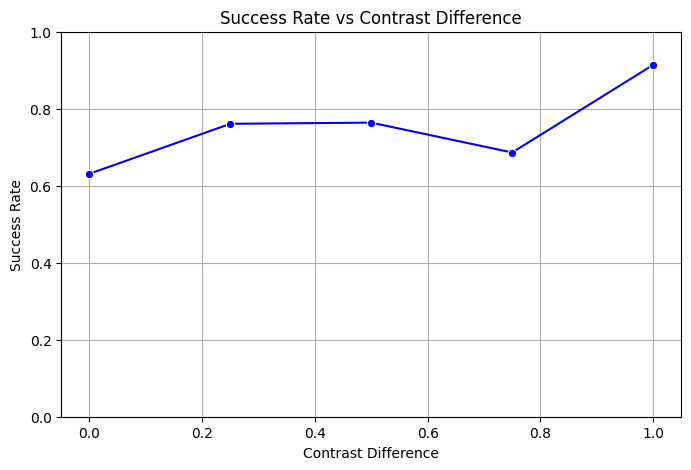

In [21]:
# Compute success rate for each contrast difference level
contrast_success_rate = (contrast_df
                         .groupby("contrast_diff")["success"]
                         .mean()
                         .reset_index()
                         .sort_values("contrast_diff"))

# Plot success rate vs contrast difference
plt.figure(figsize=(8, 5))
sns.lineplot(x="contrast_diff", y="success", data=contrast_success_rate, marker="o", color="blue")
plt.xlabel("Contrast Difference")
plt.ylabel("Success Rate")
plt.title("Success Rate vs Contrast Difference")
plt.ylim(0, 1)  # Ensure y-axis is between 0 and 1
plt.grid(True)
plt.show()

/var/folders/6k/4mxbyftd2gvdc46x5202nj5w0000gn/T/ipykernel_2365/1995585967.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="mouse_name", y="contrast_diff", data=mouse_contrast_df, palette="Set2")


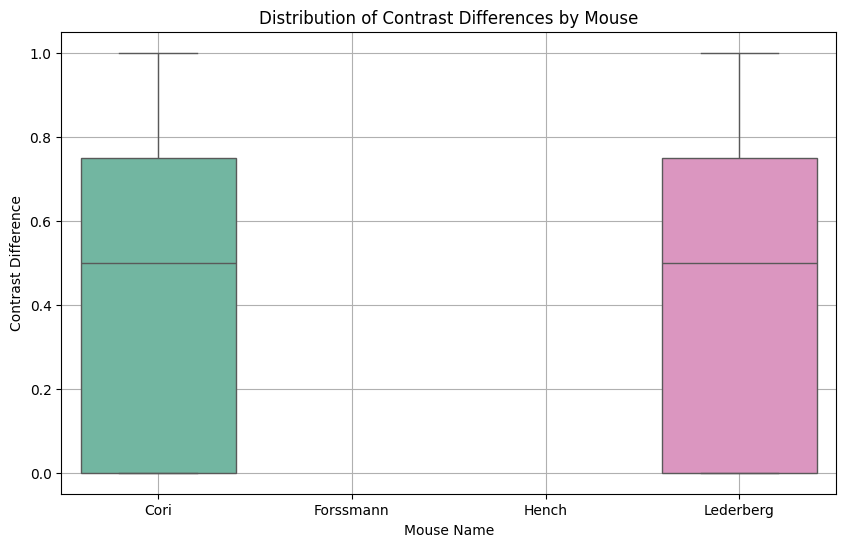

In [22]:
# Merge contrast_df with session metadata
mouse_data = []
for session_id, session in enumerate(all_sessions, start=1):
    mouse_name = session.rx2("mouse_name")[0]
    contrast_values = contrast_df.loc[contrast_df["session_id"] == session_id, "contrast_diff"].values
    for contrast in contrast_values:
        mouse_data.append({
            "session_id": session_id,
            "mouse_name": mouse_name,
            "contrast_diff": contrast
        })

mouse_contrast_df = pd.DataFrame(mouse_data)

# Plot contrast distribution per mouse
plt.figure(figsize=(10, 6))
sns.boxplot(x="mouse_name", y="contrast_diff", data=mouse_contrast_df, palette="Set2")
plt.xlabel("Mouse Name")
plt.ylabel("Contrast Difference")
plt.title("Distribution of Contrast Differences by Mouse")
plt.grid(True)
plt.show()

In [23]:
print(mouse_contrast_df["mouse_name"].value_counts())

mouse_name
Lederberg    2032
Hench        1411
Forssmann    1045
Cori          593
Name: count, dtype: int64


In [24]:
# Load all sessions (assumes 18 sessions named session1.rds to session18.rds)
all_sessions = []
for i in range(1, 19):
    file_name = f'session{i}.rds'
    file_path = os.path.join(data_path, file_name)
    session_data = read_rds(file_path)
    all_sessions.append(session_data)

# Extract session-level metadata and summary stats
session_summaries = []
for sess in all_sessions:
    mouse_name = sess.rx2('mouse_name')[0]
    date_exp = sess.rx2('date_exp')[0]
    spks = sess.rx2('spks')  # list of spike matrices (one per trial)
    first_trial_spks = np.array(spks[0])
    n_neurons = first_trial_spks.shape[0]         # number of neurons
    n_trials = len(spks)                           # number of trials
    feedback = np.array(sess.rx2('feedback_type'))
    success_rate = np.mean(feedback == 1)          # success rate (1=success, -1=failure)
    brain_area = np.array(sess.rx2('brain_area'))
    n_brain_area = len(np.unique(brain_area))
    
    session_summaries.append({
        "mouse_name": mouse_name,
        "date_exp": date_exp,
        "n_neurons": n_neurons,
        "n_trials": n_trials,
        "n_brain_area": n_brain_area,
        "success_rate": success_rate
    })

session_summary_df = pd.DataFrame(session_summaries)
print(session_summary_df)

   mouse_name    date_exp  n_neurons  n_trials  n_brain_area  success_rate
0        Cori  2016-12-14        734       114             8      0.605263
1        Cori  2016-12-17       1070       251             5      0.633466
2        Cori  2016-12-18        619       228            11      0.662281
3   Forssmann  2017-11-01       1769       249            11      0.666667
4   Forssmann  2017-11-02       1077       254            10      0.661417
5   Forssmann  2017-11-04       1169       290             5      0.741379
6   Forssmann  2017-11-05        584       252             8      0.670635
7       Hench  2017-06-15       1157       250            15      0.644000
8       Hench  2017-06-16        788       372            12      0.685484
9       Hench  2017-06-17       1172       447            13      0.619687
10      Hench  2017-06-18        857       342             6      0.795322
11  Lederberg  2017-12-05        698       340            12      0.738235
12  Lederberg  2017-12-06

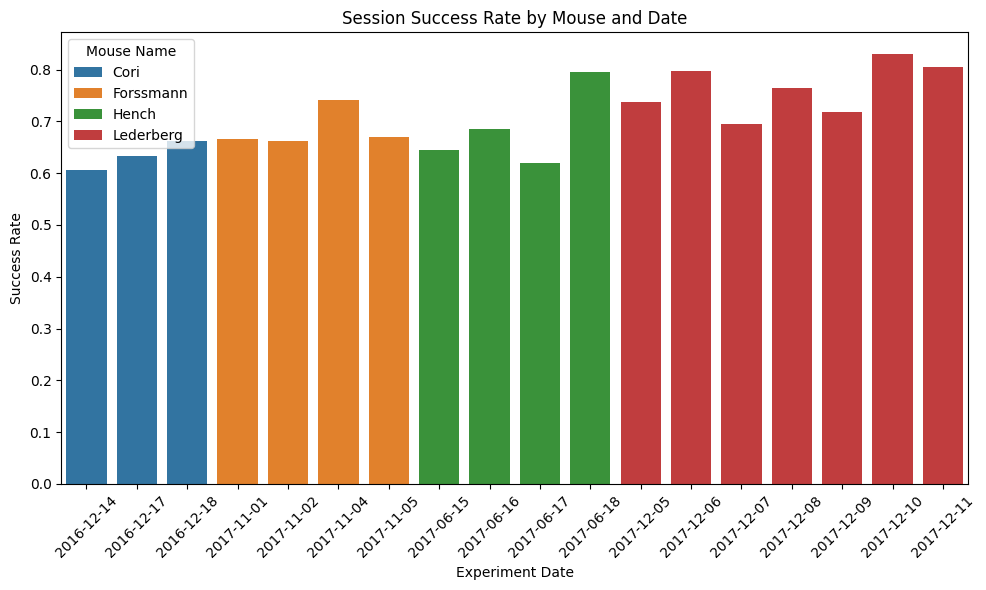

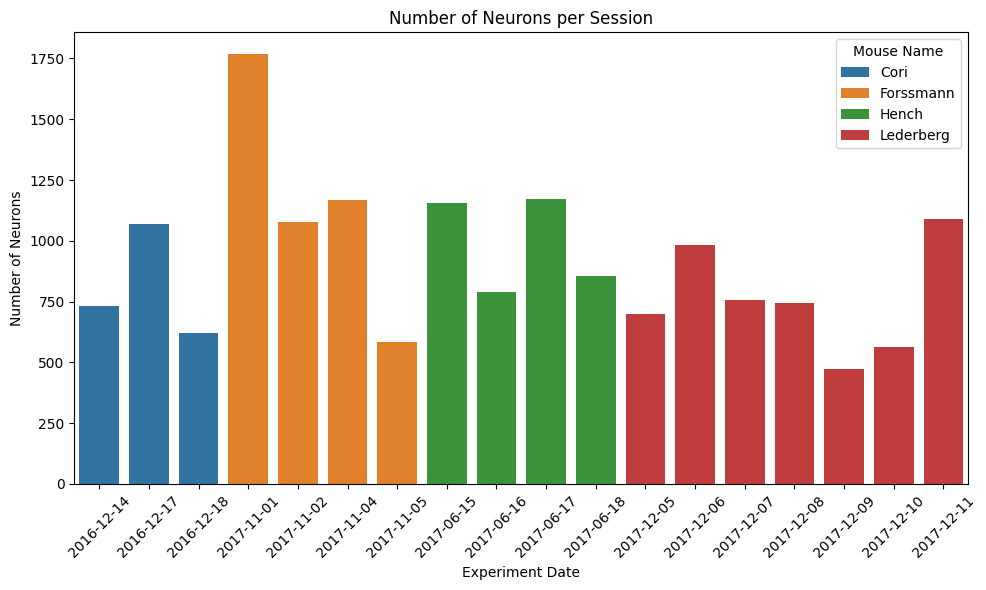

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar plot: Session success rate by date and mouse
plt.figure(figsize=(10, 6))
sns.barplot(x="date_exp", y="success_rate", hue="mouse_name", data=session_summary_df)
plt.title("Session Success Rate by Mouse and Date")
plt.xlabel("Experiment Date")
plt.ylabel("Success Rate")
plt.xticks(rotation=45)
plt.legend(title="Mouse Name")
plt.tight_layout()
plt.show()

# Bar plot: Number of neurons per session by date and mouse
plt.figure(figsize=(10, 6))
sns.barplot(x="date_exp", y="n_neurons", hue="mouse_name", data=session_summary_df)
plt.title("Number of Neurons per Session")
plt.xlabel("Experiment Date")
plt.ylabel("Number of Neurons")
plt.xticks(rotation=45)
plt.legend(title="Mouse Name")
plt.tight_layout()
plt.show()

In [26]:
# Select one session (e.g., the first session)
session = all_sessions[0]

# Extract spike data (list of matrices, one per trial) and convert to 3D NumPy array:
spks_list = session.rx2('spks')
spks_array = np.array([np.array(trial) for trial in spks_list])
print(f"Spike Data Shape: {spks_array.shape}")  # Expected: (n_trials, n_neurons, n_time_bins)

# Preview the spike matrix for the first trial
print("First trial spike matrix:")
print(spks_array[0])

# Compute percentage of zeros (indicating inactive bins)
zero_percentage = np.mean(spks_array[0] == 0) * 100
print(f"Percentage of zeroes in first trial: {zero_percentage:.2f}%")

Spike Data Shape: (114, 734, 40)
First trial spike matrix:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Percentage of zeroes in first trial: 96.26%


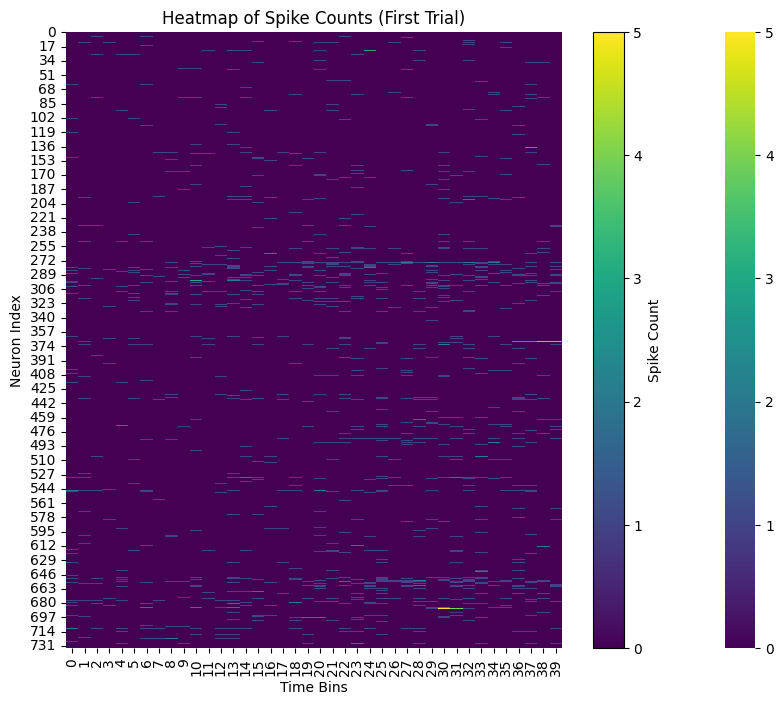

In [27]:
# Plot a heatmap of the first trial's spike matrix
plt.figure(figsize=(10, 8))
ax = sns.heatmap(spks_array[0], cmap="viridis", cbar=True)
ax.figure.colorbar(ax.collections[0], label="Spike Count")
plt.xlabel("Time Bins")
plt.ylabel("Neuron Index")
plt.title("Heatmap of Spike Counts (First Trial)")
plt.show()

In [28]:
def get_trial_data(session, trial_id):
    """
    For a given session and trial (0-indexed), compute for each brain area:
      - region_sum_spike: total spikes (sum over 40 time bins) for neurons in that area
      - region_count: number of neurons in that area
      - region_mean_spike: average spike count per neuron in that area
    Also attaches trial-level metadata (trial_id, contrast levels, feedback).
    """
    spikes = session.rx2('spks')[trial_id]
    neuron_spike = np.sum(np.array(spikes), axis=1)  # sum over time bins per neuron
    brain_area = np.array(session.rx2('brain_area'))
    
    df = pd.DataFrame({
        "neuron_spike": neuron_spike,
        "brain_area": brain_area
    })
    
    trial_df = (df.groupby("brain_area")
                .agg(region_sum_spike=("neuron_spike", "sum"),
                     region_count=("neuron_spike", "count"),
                     region_mean_spike=("neuron_spike", "mean"))
                .reset_index())
    
    # Append trial metadata
    trial_df["trial_id"] = trial_id + 1  # 1-indexed
    trial_df["contrast_left"] = session.rx2("contrast_left")[trial_id]
    trial_df["contrast_right"] = session.rx2("contrast_right")[trial_id]
    trial_df["feedback_type"] = session.rx2("feedback_type")[trial_id]
    
    return trial_df

# Example: Get region summary for trial 2 of session 1
trial_summary = get_trial_data(session, trial_id=1)
print(trial_summary)

  brain_area  region_sum_spike  region_count  region_mean_spike  trial_id  \
0        ACA              64.0           109           0.587156         2   
1        CA3             116.0            68           1.705882         2   
2         DG              53.0            34           1.558824         2   
3         LS             190.0           139           1.366906         2   
4        MOs              88.0           113           0.778761         2   
5        SUB             146.0            75           1.946667         2   
6       VISp             294.0           178           1.651685         2   
7       root              12.0            18           0.666667         2   

   contrast_left  contrast_right  feedback_type  
0            0.0             0.0            1.0  
1            0.0             0.0            1.0  
2            0.0             0.0            1.0  
3            0.0             0.0            1.0  
4            0.0             0.0            1.0  
5     

In [29]:
def get_trial_bin_average(session):
    """
    For each trial in a session, compute the average spike count per time bin 
    (averaging over all neurons). Returns a DataFrame with columns bin1...bin40,
    plus trial-level metadata.
    """
    spks = session.rx2('spks')
    trial_avgs = []
    n_trials = len(spks)
    # Assuming all trials have the same number of time bins:
    n_bins = np.array(spks[0]).shape[1]
    
    for trial_id in range(n_trials):
        trial_matrix = np.array(spks[trial_id])  # shape: (n_neurons, n_bins)
        bin_avg = np.mean(trial_matrix, axis=0)    # average per time bin
        trial_avgs.append(bin_avg)
    
    bin_columns = [f"bin{i+1}" for i in range(n_bins)]
    df = pd.DataFrame(trial_avgs, columns=bin_columns)
    
    # Add trial metadata
    df["trial_id"] = np.arange(1, n_trials + 1)
    df["contrast_left"] = np.array(session.rx2("contrast_left"))
    df["contrast_right"] = np.array(session.rx2("contrast_right"))
    df["feedback_type"] = np.array(session.rx2("feedback_type"))
    return df

# Example: Get trial bin averages for session 1
trial_bin_avg_df = get_trial_bin_average(session)
print(trial_bin_avg_df.head())

       bin1      bin2      bin3      bin4      bin5      bin6      bin7  \
0  0.049046  0.036785  0.017711  0.014986  0.032698  0.028610  0.031335   
1  0.029973  0.031335  0.034060  0.027248  0.025886  0.031335  0.021798   
2  0.049046  0.050409  0.029973  0.043597  0.024523  0.040872  0.029973   
3  0.055858  0.053134  0.027248  0.061308  0.057221  0.059946  0.044959   
4  0.027248  0.043597  0.031335  0.024523  0.044959  0.038147  0.046322   

       bin8      bin9     bin10  ...     bin35     bin36     bin37     bin38  \
0  0.012262  0.034060  0.019074  ...  0.031335  0.036785  0.050409  0.054496   
1  0.023161  0.023161  0.034060  ...  0.042234  0.053134  0.061308  0.038147   
2  0.038147  0.034060  0.042234  ...  0.029973  0.042234  0.035422  0.027248   
3  0.028610  0.039510  0.035422  ...  0.043597  0.038147  0.027248  0.034060   
4  0.057221  0.047684  0.016349  ...  0.039510  0.047684  0.035422  0.028610   

      bin39     bin40  trial_id  contrast_left  contrast_right  feed

In [30]:
def get_trial_bin_average(session):
    spks = session.rx2("spks")
    trial_avgs = []
    n_trials = len(spks)
    n_bins = np.array(spks[0]).shape[1]
    
    for trial_id in range(n_trials):
        trial_matrix = np.array(spks[trial_id])
        bin_avg = np.mean(trial_matrix, axis=0)
        trial_avgs.append(bin_avg)
        
    bin_columns = [f"bin{i+1}" for i in range(n_bins)]
    df = pd.DataFrame(trial_avgs, columns=bin_columns)
    df["trial_id"] = np.arange(1, n_trials+1)
    df["contrast_left"] = np.array(session.rx2("contrast_left"))
    df["contrast_right"] = np.array(session.rx2("contrast_right"))
    df["feedback_type"] = np.array(session.rx2("feedback_type"))
    # Compute contrast difference
    df["contrast_diff"] = np.abs(df["contrast_left"] - df["contrast_right"])
    return df

trial_dfs = []
for idx, sess in enumerate(all_sessions):
    df_trial = get_trial_bin_average(sess)
    df_trial["session_id"] = idx + 1
    df_trial["mouse_name"] = sess.rx2("mouse_name")[0]
    trial_dfs.append(df_trial)

# Combine trials from all sessions into one DataFrame
full_functional_df = pd.concat(trial_dfs, ignore_index=True)
print(full_functional_df.head())

       bin1      bin2      bin3      bin4      bin5      bin6      bin7  \
0  0.049046  0.036785  0.017711  0.014986  0.032698  0.028610  0.031335   
1  0.029973  0.031335  0.034060  0.027248  0.025886  0.031335  0.021798   
2  0.049046  0.050409  0.029973  0.043597  0.024523  0.040872  0.029973   
3  0.055858  0.053134  0.027248  0.061308  0.057221  0.059946  0.044959   
4  0.027248  0.043597  0.031335  0.024523  0.044959  0.038147  0.046322   

       bin8      bin9     bin10  ...     bin38     bin39     bin40  trial_id  \
0  0.012262  0.034060  0.019074  ...  0.054496  0.039510  0.039510         1   
1  0.023161  0.023161  0.034060  ...  0.038147  0.028610  0.025886         2   
2  0.038147  0.034060  0.042234  ...  0.027248  0.038147  0.031335         3   
3  0.028610  0.039510  0.035422  ...  0.034060  0.038147  0.044959         4   
4  0.057221  0.047684  0.016349  ...  0.028610  0.028610  0.032698         5   

   contrast_left  contrast_right  feedback_type  contrast_diff  sess

In [31]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# Define the predictive features.
# Here we use session_id, trial_id, contrast_left, contrast_right, contrast_diff, and all bin features.
bin_cols = [col for col in full_functional_df.columns if col.startswith("bin")]
predictive_features = ["session_id", "trial_id", "contrast_left", "contrast_right", "contrast_diff"] + bin_cols

# Prepare feature matrix X and target y
bin_cols = [col for col in full_functional_df.columns if col.startswith("bin")]
predictive_features = ["session_id", "trial_id", "contrast_left", "contrast_right", "contrast_diff"] + bin_cols

X = full_functional_df[predictive_features].copy()
X["session_id"] = pd.to_numeric(X["session_id"])
X["trial_id"] = pd.to_numeric(X["trial_id"])
y = full_functional_df["feedback_type"]

# Convert y: map -1 -> 0 and keep 1 as 1
y = np.where(y == -1, 0, 1)

# Split into training and unused parts
from sklearn.model_selection import train_test_split
X_train, X_unused, y_train, y_unused = train_test_split(X, y, test_size=0.2, random_state=123)

# Train an XGBoost classifier.
from xgboost import XGBClassifier
model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
model.fit(X_train, y_train)

print("Model training complete.")

Model training complete.


/Users/shantanu/rpy2_env/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [12:24:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [32]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# Further split X_unused to create test set
X_test, _, y_test, _ = train_test_split(X_unused, y_unused, test_size=0.5, random_state=42)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for AUROC

In [33]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

Model Accuracy: 0.6988


In [34]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 45 100]
 [ 53 310]]
